In [1]:
from keras.models import load_model
from keras.models import Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from sklearn.metrics import classification_report, confusion_matrix

import multiprocessing

from utils.DomainImageGenerator import DomainImageGenerator

2025-07-27 15:32:56.505120: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the Dataset as Generators so not all images are loaded into ram at the same time. The generator class loads the needed images per batch
cpu_count = multiprocessing.cpu_count()
njobs = int(cpu_count * 0.9) # Just set to use some percent of cpus
max_queue_size = 15
use_multiprocessing = True

model = load_model("../models/HyperparameterSeach.keras")
test_gen = DomainImageGenerator("prepared/test.csv", batch_size=64, shuffle=False, n_jobs=njobs, use_multiprocessing=use_multiprocessing, max_queue_size=max_queue_size)

In [3]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9725 - loss: 0.0862
Test Accuracy: 0.9819
Test Loss: 0.0574


In [4]:
test_gen.set_Mode_To_Rescale(rescale=True, source="CIFAR-10")
test_loss_rescale, test_acc_rescale = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc_rescale:.4f}")
print(f"Test Loss: {test_loss_rescale:.4f}")
test_gen.set_Mode_To_Rescale(rescale=False)

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9926 - loss: 0.0249
Test Accuracy: 0.9943
Test Loss: 0.0205


In [5]:
# Shuffle needs to be off for this to make sense. Shuffling can be done by hand with test_gen.shuffle_indexes()

test_gen.shuffle_indexes()
y_true = test_gen.getAllLabels()
y_pred = model.predict(test_gen)

test_gen.set_Mode_To_Rescale(rescale=True, source="CIFAR-10")
y_pred_rescaled = model.predict(test_gen)
test_gen.set_Mode_To_Rescale(rescale=False)

y_pred_binary = (y_pred > 0.5).astype(int).flatten()
y_pred_binary_rescaled = (y_pred_rescaled > 0.5).astype(int).flatten()

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step


In [6]:
y_greater = y_pred[(y_pred > 0.5)]
predictions_greater_half = len(y_greater)

values = [0.6, 0.7, 0.8, 0.9, 0.95, 0.98]
print(f"There are {predictions_greater_half} predictions greater then 0.5")
for num in values:
    y_greater_num = y_greater[(y_greater > num)]
    print(f"\n{len(y_greater_num)} predictions are greater then {num}")
    print(f"That is {(len(y_greater_num)/predictions_greater_half) * 100:.1f} percent of all predictions greater then 0.5")

There are 70944 predictions greater then 0.5

70668 predictions are greater then 0.6
That is 99.6 percent of all predictions greater then 0.5

70364 predictions are greater then 0.7
That is 99.2 percent of all predictions greater then 0.5

69868 predictions are greater then 0.8
That is 98.5 percent of all predictions greater then 0.5

68676 predictions are greater then 0.9
That is 96.8 percent of all predictions greater then 0.5

66990 predictions are greater then 0.95
That is 94.4 percent of all predictions greater then 0.5

63109 predictions are greater then 0.98
That is 89.0 percent of all predictions greater then 0.5


In [7]:
y_less = y_pred[(y_pred < 0.5)]
predictions_less_half = len(y_less)

values = [0.4, 0.3, 0.2, 0.1, 0.05, 0.02]
print(f"There are {predictions_less_half} predictions less then 0.5")
for num in values:
    y_less_num = y_less[(y_less < num)]
    print(f"\n{len(y_less_num)} predictions are smaller then {num}")
    print(f"That is {(len(y_less_num)/predictions_less_half) * 100:.1f} percent of all predictions smaller then 0.5")

There are 19056 predictions less then 0.5

18814 predictions are smaller then 0.4
That is 98.7 percent of all predictions smaller then 0.5

18549 predictions are smaller then 0.3
That is 97.3 percent of all predictions smaller then 0.5

18207 predictions are smaller then 0.2
That is 95.5 percent of all predictions smaller then 0.5

17623 predictions are smaller then 0.1
That is 92.5 percent of all predictions smaller then 0.5

16945 predictions are smaller then 0.05
That is 88.9 percent of all predictions smaller then 0.5

15910 predictions are smaller then 0.02
That is 83.5 percent of all predictions smaller then 0.5


In [8]:
print(classification_report(y_true, y_pred_binary, target_names=["CIFAR-10", "ImageNet"]))

              precision    recall  f1-score   support

    CIFAR-10       0.98      0.94      0.96     20000
    ImageNet       0.98      1.00      0.99     70000

    accuracy                           0.98     90000
   macro avg       0.98      0.97      0.97     90000
weighted avg       0.98      0.98      0.98     90000



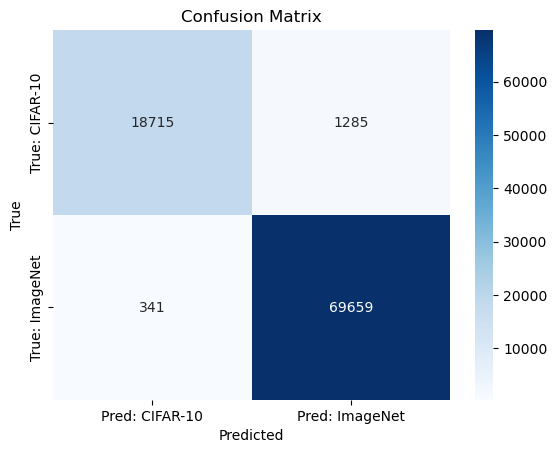

In [9]:
cm = confusion_matrix(y_true, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: CIFAR-10", "Pred: ImageNet"],
            yticklabels=["True: CIFAR-10", "True: ImageNet"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

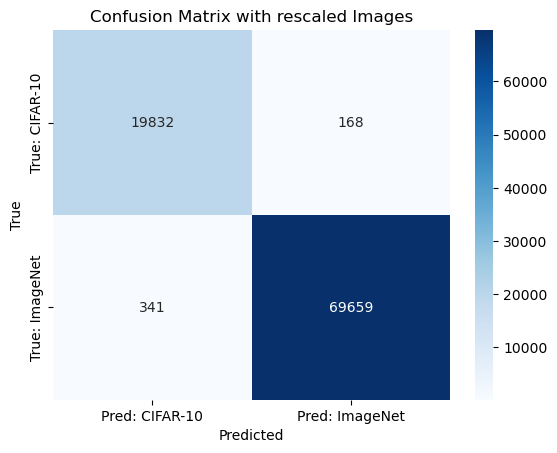

In [10]:
cm = confusion_matrix(y_true, y_pred_binary_rescaled)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: CIFAR-10", "Pred: ImageNet"],
            yticklabels=["True: CIFAR-10", "True: ImageNet"])
plt.title("Confusion Matrix with rescaled Images")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [11]:
indexes = test_gen.return_Indexes()
categories = test_gen.return_Category_by_Index(indexes)

In [12]:
# Build the DataFrame
df_images = pd.DataFrame({
    "index": indexes,
    "category": categories,
    "y_true": y_true,
    "prediction": y_pred.flatten(),
    "rescaled_prediction": y_pred_rescaled.flatten() 
})

In [13]:
df_cifar = df_images[df_images["y_true"] == 0].copy()
df_imagenet = df_images[df_images["y_true"] == 1].copy()

In [14]:
print(f"CIFAR-10: {len(df_cifar)} images")
print(f"ImageNet: {len(df_imagenet)} images")

print(df_cifar.head())
print(df_imagenet.head())

CIFAR-10: 20000 images
ImageNet: 70000 images
    index  category  y_true    prediction  rescaled_prediction
1   72169      ship       0  7.281266e-04             0.000864
3   55716      frog       0  6.106767e-04             0.000522
8     758  airplane       0  8.844613e-01             0.000003
17     70  airplane       0  6.340948e-07             0.000001
20  19655      bird       0  9.549717e-06             0.000021
   index category  y_true  prediction  rescaled_prediction
0  34314      cat       1    0.991520             0.991520
2  66900    horse       1    0.999707             0.999707
4  26272     bird       1    0.999950             0.999950
5  30426      cat       1    0.966471             0.966471
6  24405     bird       1    0.999775             0.999775


In [15]:
print(np.unique(df_images["category"]))

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [16]:
def from_DataFrame_get_subDataFrame_of_category(df, category):
    return df[df["category"] == category]

Loading images: 100%|███████████████████████████| 8/8 [00:00<00:00, 1416.04it/s]


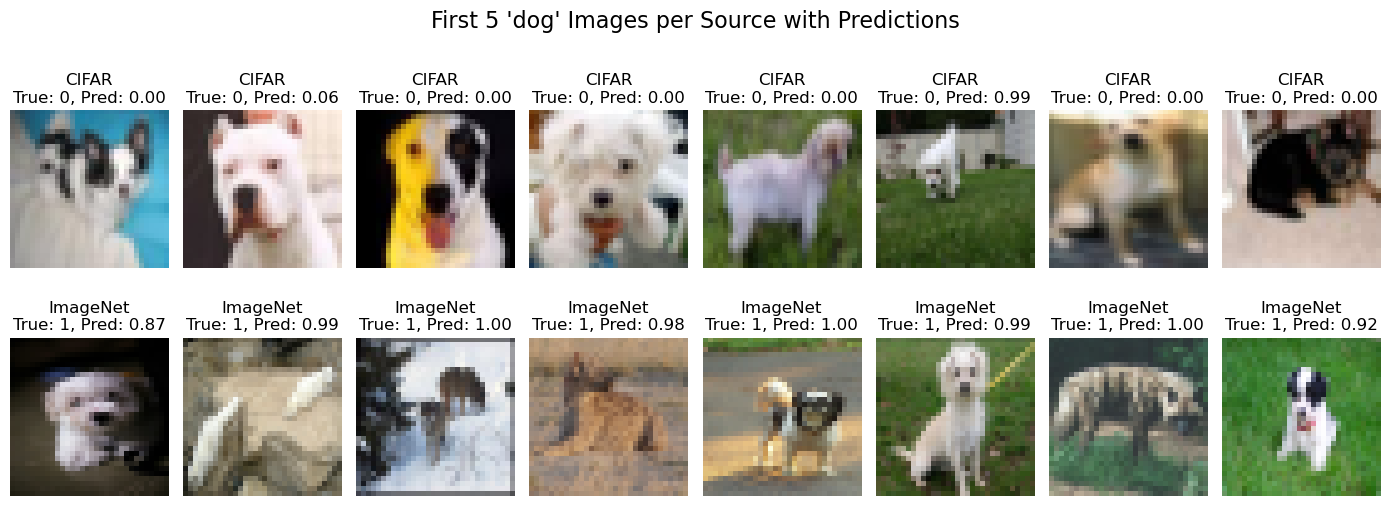

In [17]:
category = "dog"
picture_count = 8
start_idx_cifar = 8
start_idx_imagenet = 32
fig, axs = plt.subplots(2, picture_count, figsize=(14, 5))

# Filter sub-DataFrames
cifar_sub_df = from_DataFrame_get_subDataFrame_of_category(df_cifar, category)
imagenet_sub_df = from_DataFrame_get_subDataFrame_of_category(df_imagenet, category)

# Get images by index
cifar_images = test_gen.return_Img_by_Index(cifar_sub_df["index"][start_idx_cifar:picture_count+start_idx_cifar])
imagenet_images = test_gen.return_Img_by_Index(imagenet_sub_df["index"][start_idx_imagenet:picture_count+start_idx_imagenet])

# CIFAR-10 (top row)
for i in range(picture_count):
    img = cifar_images[i]
    row = cifar_sub_df.iloc[start_idx_cifar+i]
    title = f"CIFAR\nTrue: {int(row['y_true'])}, Pred: {row['prediction']:.2f}"
    axs[0, i].imshow(img)
    axs[0, i].set_title(title)
    axs[0, i].axis("off")

# ImageNet (bottom row)
for i in range(picture_count):
    img = imagenet_images[i]
    row = imagenet_sub_df.iloc[start_idx_imagenet+i]
    title = f"ImageNet\nTrue: {int(row['y_true'])}, Pred: {row['prediction']:.2f}"
    axs[1, i].imshow(img)
    axs[1, i].set_title(title)
    axs[1, i].axis("off")

plt.tight_layout()
plt.suptitle(f"First 5 '{category}' Images per Source with Predictions", y=1.08, fontsize=16)
plt.show()

Loading images: 100%|████████████████████████████| 8/8 [00:00<00:00, 621.98it/s]


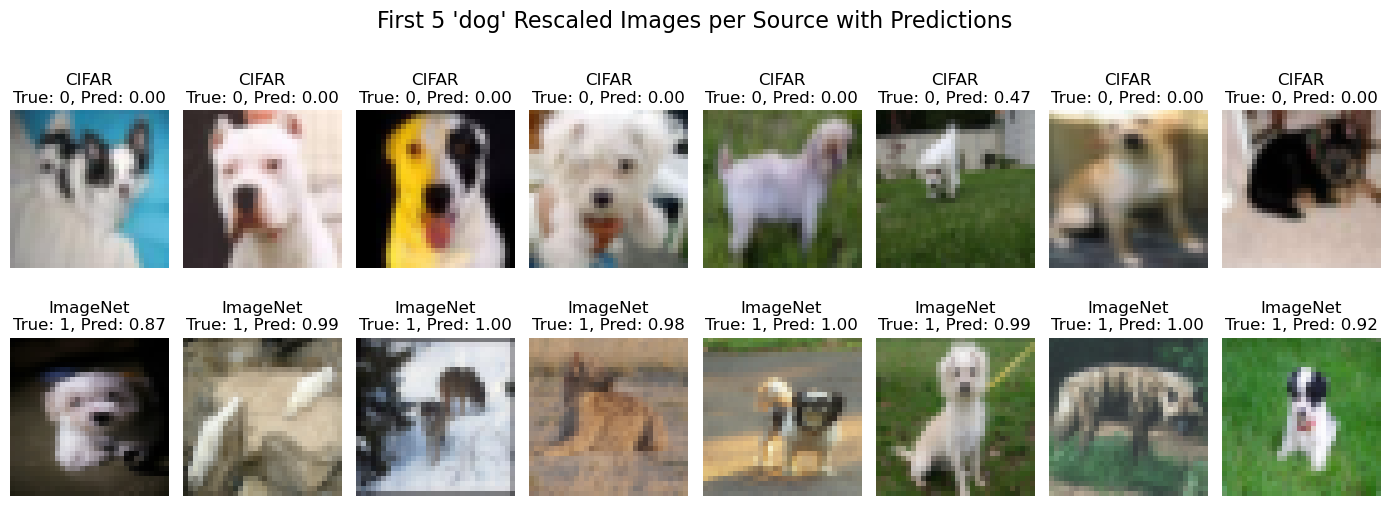

In [18]:
category = "dog"
picture_count = 8
start_idx_cifar = 8
start_idx_imagenet = 32
fig, axs = plt.subplots(2, picture_count, figsize=(14, 5))

# Filter sub-DataFrames
cifar_sub_df = from_DataFrame_get_subDataFrame_of_category(df_cifar, category)
imagenet_sub_df = from_DataFrame_get_subDataFrame_of_category(df_imagenet, category)

# Get images by index
cifar_images = test_gen.return_Img_by_Index(cifar_sub_df["index"][start_idx_cifar:picture_count+start_idx_cifar], rescaled=True)
imagenet_images = test_gen.return_Img_by_Index(imagenet_sub_df["index"][start_idx_imagenet:picture_count+start_idx_imagenet], rescaled=True)

# CIFAR-10 (top row)
for i in range(picture_count):
    img = cifar_images[i]
    row = cifar_sub_df.iloc[start_idx_cifar+i]
    title = f"CIFAR\nTrue: {int(row['y_true'])}, Pred: {row['rescaled_prediction']:.2f}"
    axs[0, i].imshow(img)
    axs[0, i].set_title(title)
    axs[0, i].axis("off")

# ImageNet (bottom row)
for i in range(picture_count):
    img = imagenet_images[i]
    row = imagenet_sub_df.iloc[start_idx_imagenet+i]
    title = f"ImageNet\nTrue: {int(row['y_true'])}, Pred: {row['rescaled_prediction']:.2f}"
    axs[1, i].imshow(img)
    axs[1, i].set_title(title)
    axs[1, i].axis("off")

plt.tight_layout()
plt.suptitle(f"First 5 '{category}' Rescaled Images per Source with Predictions", y=1.08, fontsize=16)
plt.show()

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 40)     │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 40)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 40)     │        14,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 40)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1440)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1440)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       184,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 600,413 (2.29 MB)

 Trainable params: 200,137 (781.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 400,276 (1.53 MB)

In [20]:
def visualize_activations(model, image, max_filters=6):
    """
    Visualize intermediate activations after each layer for a single image.

    Parameters:
    - model: Trained Keras model
    - image: Numpy array of shape (32, 32, 3)
    - max_filters: How many filters to display per conv layer
    """
    # Show original image
    fig, axs = plt.subplots(1, 4, figsize=(4 * 2.5, 2.5))
    axs[0].imshow(image)
    axs[0].set_title("Original Image")
    axs[0].axis('off')
    for i in range(3):
        axs[i+1].imshow(image[:,:,i])
        axs[i+1].set_title(f"Original Image Channel {i+1}")
        axs[i+1].axis('off')
    plt.tight_layout()
    plt.show()
    
    # Prepare image as batch input
    img_input = np.expand_dims(image, axis=0)

    # Get intermediate outputs
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = Model(inputs=model.layers[0].input, outputs=layer_outputs)
    activations = activation_model.predict(img_input)

    # Visualize outputs
    for i, activation in enumerate(activations):
        if len(activation.shape) == 4:  # Conv/Pool layers: (1, H, W, C)
            num_filters = min(activation.shape[-1], max_filters)
            fig, axs = plt.subplots(1, num_filters, figsize=(num_filters * 2.5, 2.5))
            for j in range(num_filters):
                axs[j].imshow(activation[0, :, :, j], cmap='viridis')
                axs[j].axis('off')
                axs[j].set_title(f"Filter {j + 1}")
            plt.suptitle(f"Layer {i}: {model.layers[i].name} → shape {activation.shape[1:]}", fontsize=12)
            plt.tight_layout()
            plt.show()
        elif len(activation.shape) == 2:  # Dense layer: (1, N)
            print(f"Layer {i}: {model.layers[i].name} → Dense output shape: {activation.shape}")
            print(f"Output values (first 10): {activation[0][:36]}")


In [21]:
layer = model.layers[0] # layer.name returns 'conv2d'

# Extract weights from the Conv2D layer
kernels, biases = layer.get_weights()  # shape: (3, 3, 3, num_filters) for a 3x3 RGB kernel, num_filters filters
print("Kernel shape:", kernels.shape)
print(layer.input)

Kernel shape: (3, 3, 3, 40)
<KerasTensor shape=(None, 32, 32, 3), dtype=float32, sparse=False, name=input_layer>


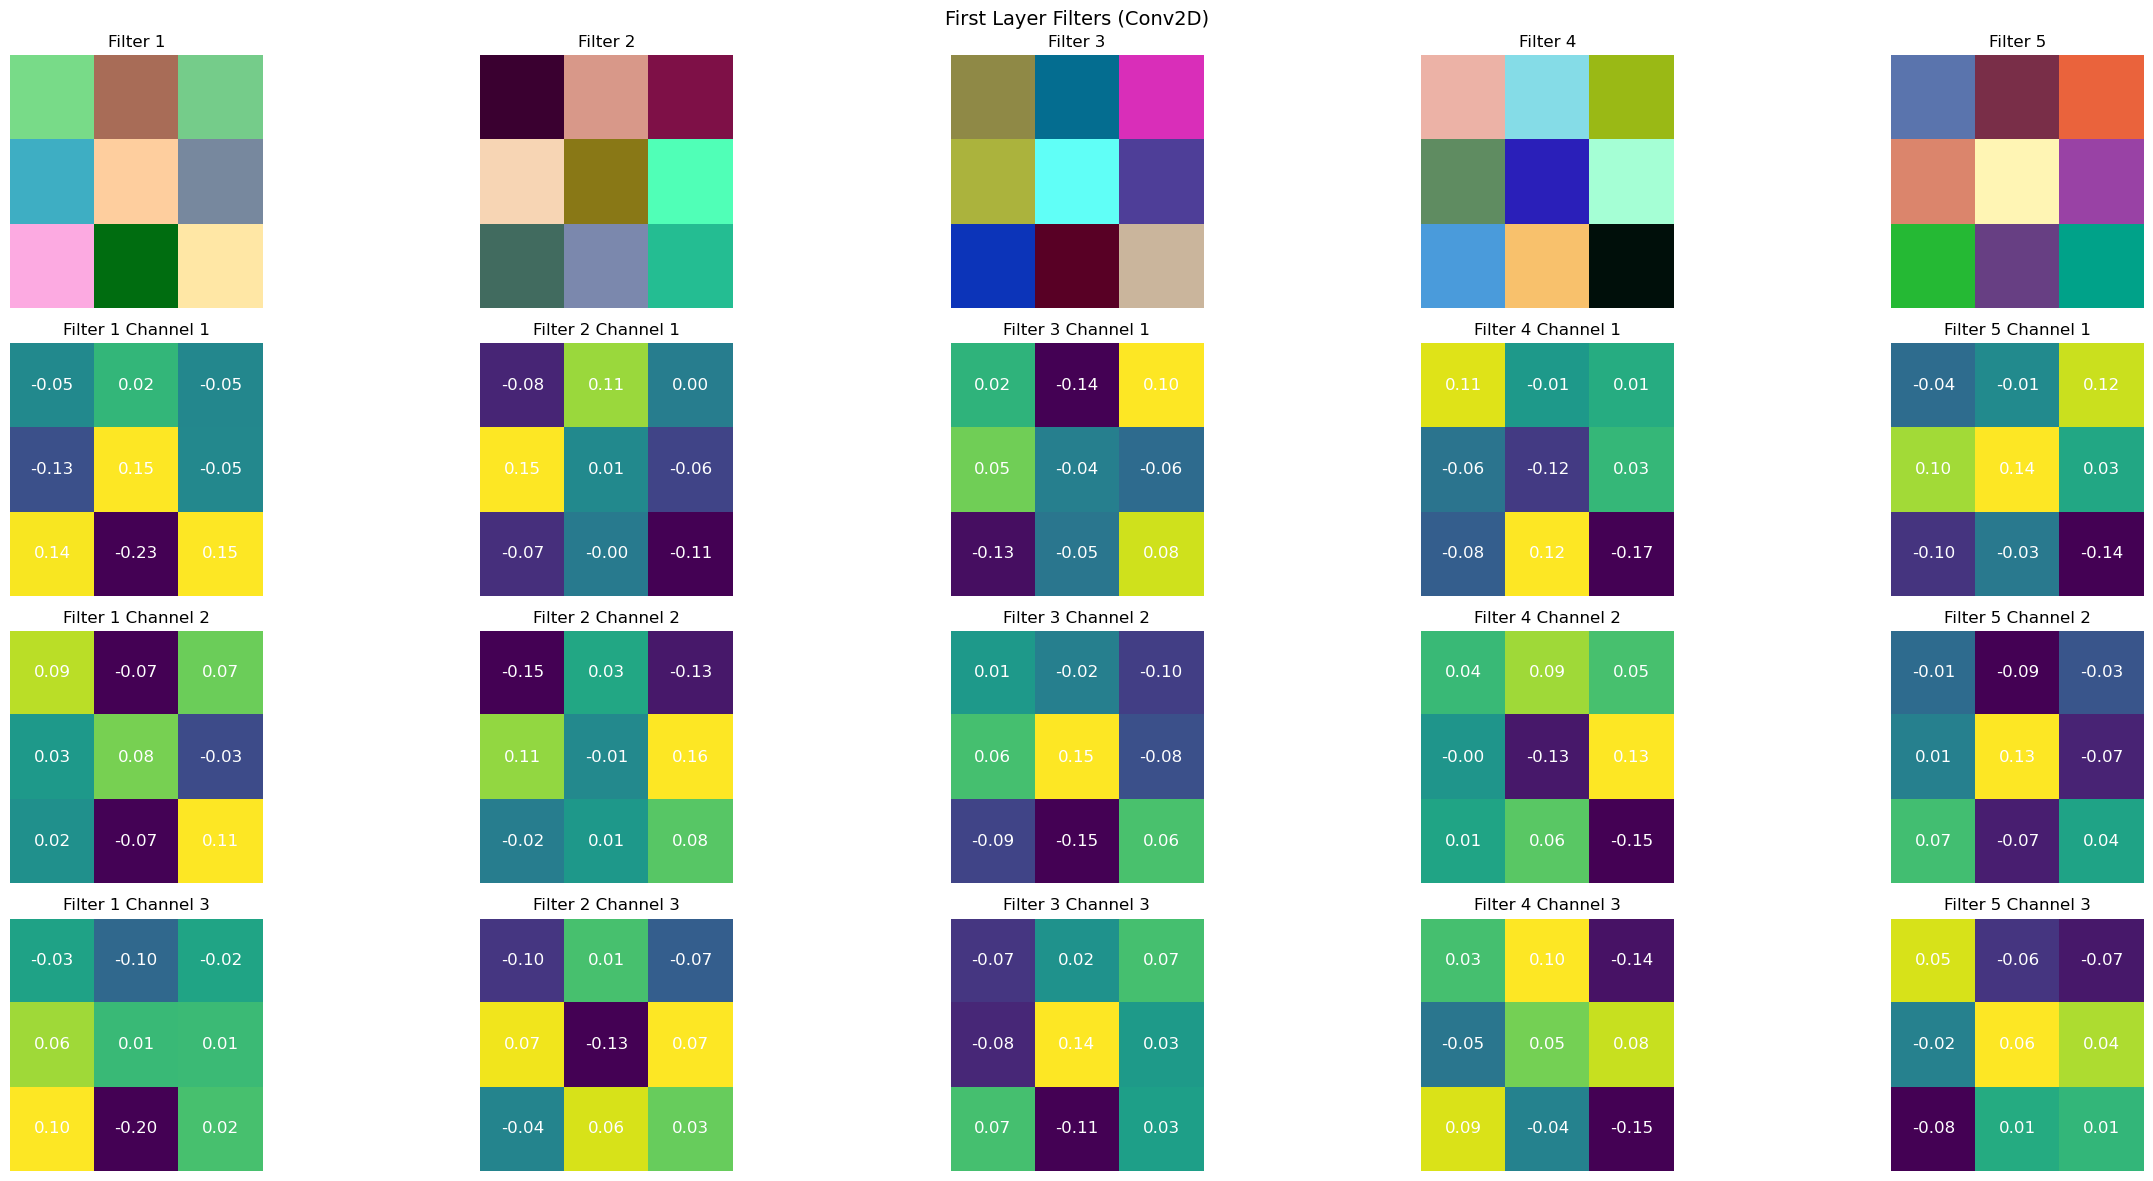

In [22]:
# Choose the first few filters
n_filters_to_show = np.min([5, kernels.shape[3]])
fig, axs = plt.subplots(4, n_filters_to_show, figsize=(5 * n_filters_to_show, 12))
axs = axs.flatten()

for i in range(n_filters_to_show):
    # Normalize for visualization
    kernel = kernels[:, :, :, i]
    kernel_min, kernel_max = kernel.min(), kernel.max()
    kernel_vis = (kernel - kernel_min) / (kernel_max - kernel_min)

    axs[i].imshow(kernel_vis)
    axs[i].set_title(f"Filter {i+1}")
    axs[i].axis('off')

    for j in range(3):
        kernel_channel_j = kernel[:,:,j]
        kernel_channel_j_min, kernel_channel_j_max = kernel_channel_j.min(), kernel_channel_j.max()
        kernel_vis_channel_j = (kernel_channel_j - kernel_channel_j_min) / (kernel_channel_j_max - kernel_channel_j_min)
        
        axs[i + n_filters_to_show * (j+1)].imshow(kernel_vis_channel_j)
        axs[i + n_filters_to_show * (j+1)].set_title(f"Filter {i+1} Channel {j+1}")
        axs[i + n_filters_to_show * (j+1)].axis('off')
        
        #for k in range(kernel_vis.shape[0]):
            #for z in range(kernel_vis.shape[1]):
               # axs[i + n_filters_to_show * (j+1)].text(z, k, f"{kernel_vis_channel_j[k, z]:.2f}",
                     #ha='center', va='center', color='white', fontsize=12)

        for k in range(kernel_vis.shape[0]):
            for z in range(kernel_vis.shape[1]):
                axs[i + n_filters_to_show * (j+1)].text(z, k, f"{kernel_channel_j[k, z]:.2f}",
                     ha='center', va='center', color='white', fontsize=12)

plt.suptitle("First Layer Filters (Conv2D)", fontsize=14)
plt.tight_layout()
plt.show()


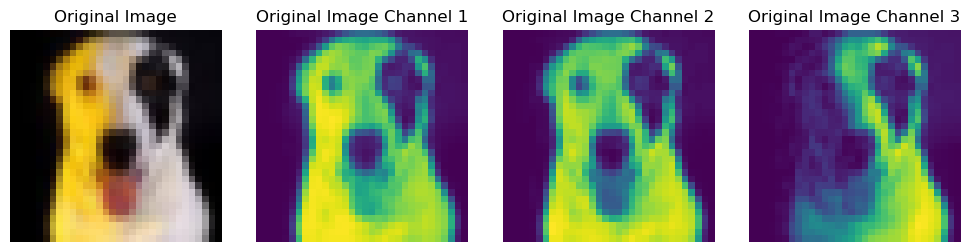

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


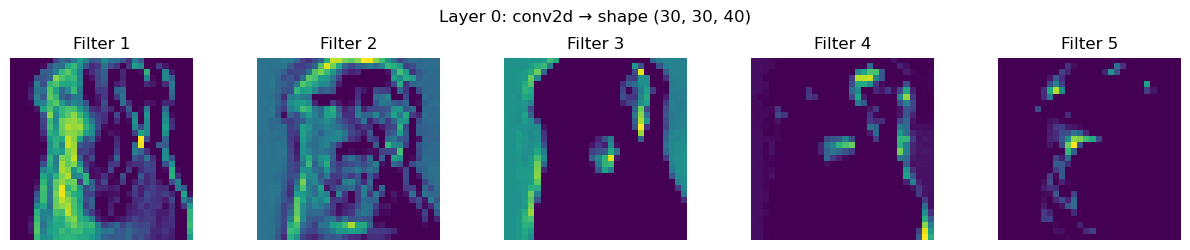

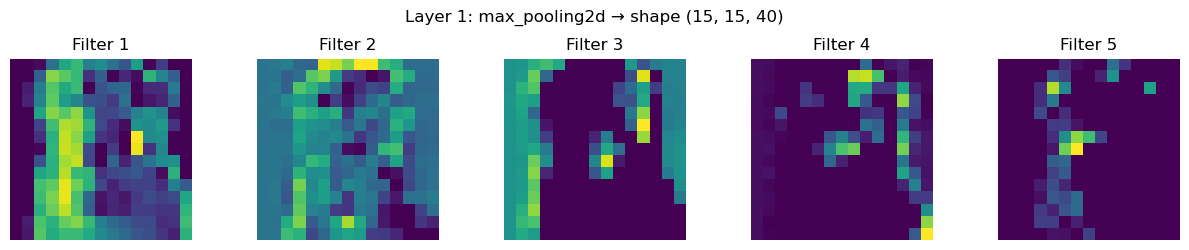

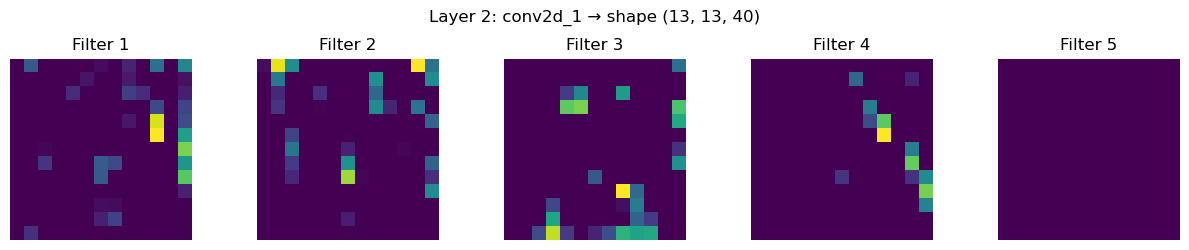

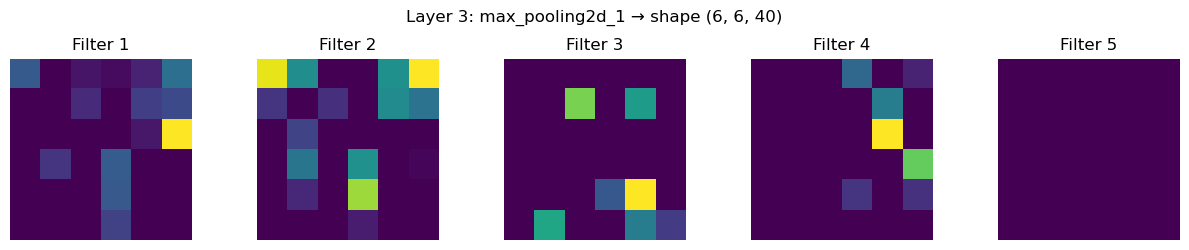

Layer 4: flatten → Dense output shape: (1, 1440)
Output values (first 10): [0.04523741 0.10048302 0.         0.         0.         0.
 0.         0.         0.         0.         0.06177405 0.
 0.         0.         0.         0.         0.         0.02125695
 0.03762378 0.0139311  0.         0.         0.         0.
 0.         0.00613358 0.09737492 0.         0.         0.
 0.00255315 0.07654761 0.         0.         0.         0.        ]
Layer 5: dropout → Dense output shape: (1, 1440)
Output values (first 10): [0.04523741 0.10048302 0.         0.         0.         0.
 0.         0.         0.         0.         0.06177405 0.
 0.         0.         0.         0.         0.         0.02125695
 0.03762378 0.0139311  0.         0.         0.         0.
 0.         0.00613358 0.09737492 0.         0.         0.
 0.00255315 0.07654761 0.         0.         0.         0.        ]
Layer 6: dense → Dense output shape: (1, 128)
Output values (first 10): [0.04407337 0.03056078 0.47710314 0.

In [23]:
img = cifar_images[2]
visualize_activations(model, img, max_filters=5)

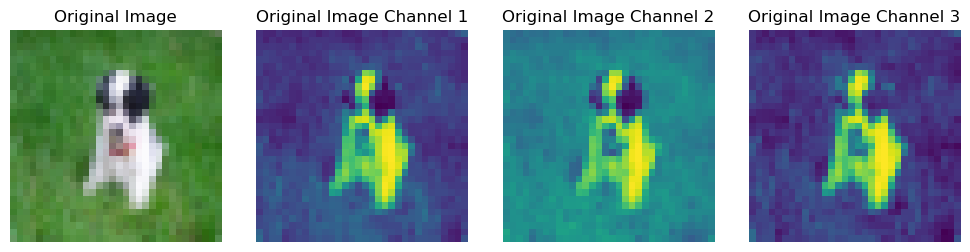

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


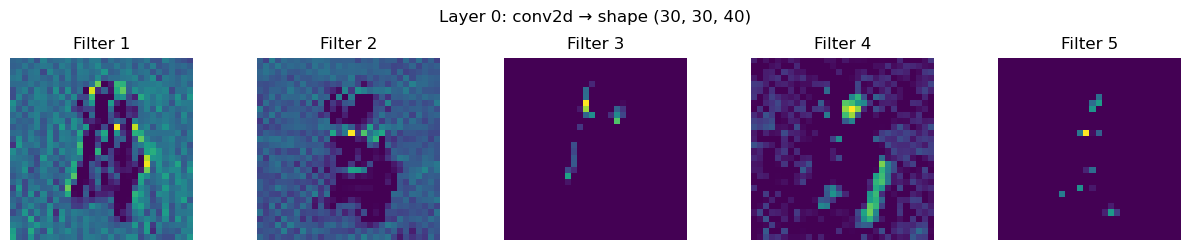

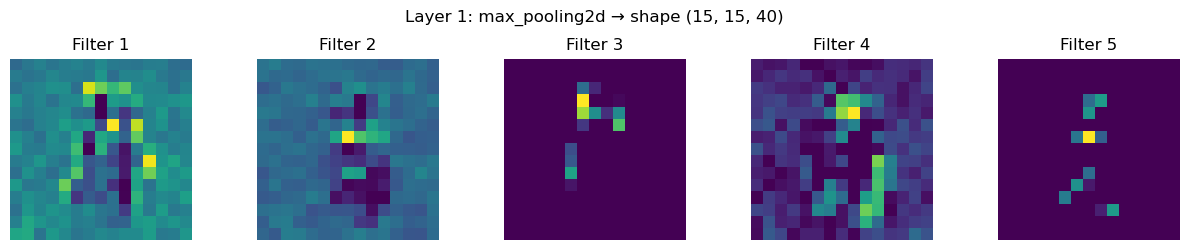

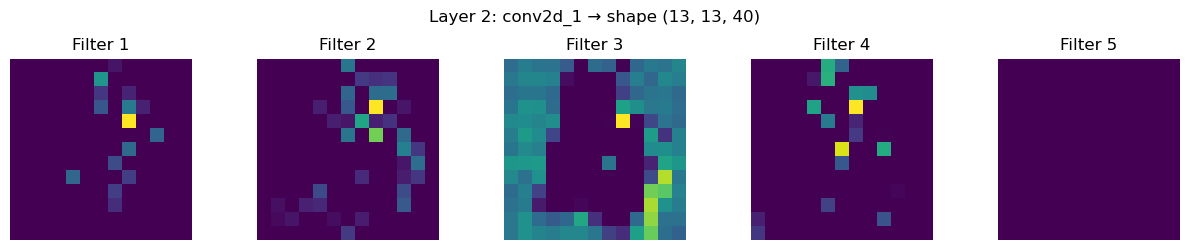

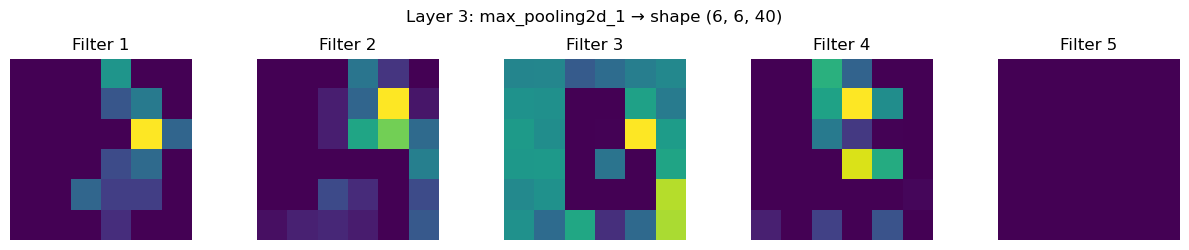

Layer 4: flatten → Dense output shape: (1, 1440)
Output values (first 10): [0.         0.         0.08022846 0.         0.         0.
 0.         0.         0.         0.0017674  0.08155481 0.02038874
 0.         0.         0.         0.         0.         0.
 0.00091613 0.         0.         0.         0.         0.
 0.         0.         0.         0.01129948 0.         0.
 0.         0.         0.         0.         0.         0.        ]
Layer 5: dropout → Dense output shape: (1, 1440)
Output values (first 10): [0.         0.         0.08022846 0.         0.         0.
 0.         0.         0.         0.0017674  0.08155481 0.02038874
 0.         0.         0.         0.         0.         0.
 0.00091613 0.         0.         0.         0.         0.
 0.         0.         0.         0.01129948 0.         0.
 0.         0.         0.         0.         0.         0.        ]
Layer 6: dense → Dense output shape: (1, 128)
Output values (first 10): [0.13502198 0.1123734  0.36825836 0.

array([[0.00135231]], dtype=float32)

In [24]:
img = imagenet_images[-1]
visualize_activations(model, img, max_filters=5)
model.predict(np.expand_dims(img, axis=0))